# Graph generation, pruning and minor-embedding of a JSS problem 


In this notebook is demonstrated 2 steps of the workflow needed to resolve a JSS problem using quantum annealing.

* A preliminar step would be to find the QUBO formulation of the target problem, in this instance the JSS already comes in the shape of a QUBO instance.

* The first step is to generate the graph representation of the problem, assigning a node to every variable and then connecting them with edges corresponding to the $x_ix_j$ terms in the constraints.
After that is convinient to prune the graph of useless nodes and edges exploiting the problem structure.

* The second section of the notebook present 2 ways of performing the minor-embedding of the logical graph on the target(hardware) graph.
The first method is given by the D'Wave API and is based on euristics while the second is an IP approach to the problem, expressing the proprieties of the desired graph as constraints it is possible to minimize the number of qubit used to embed the problem.


NOTE: the cells with the functions definitions are here only for completeness purpose, everything is included in 'ip_embed.py' and 'jss_graph.py', so the import of those modules is enough to run the notebook

# IMPORTS

In [ ]:
!pip install networkx
!pip install dwave-ocean-sdk
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import random
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import copy

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go

from itertools import product
from dwave.embedding import pegasus
import dwave.inspector
import minorminer
import dwave_networkx as dnx

import gurobipy as gb
from gurobipy import GRB

from jss_graph import *
from ip_embed import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Uni/gurobi.lic','r') as f:
  lic = f.read()

ls = lic.split('\n')
access_id = ls[3].split('=')[1]
secret = ls[4].split('=')[1]
id = int(ls[5].split('=')[1])

params = {
"WLSACCESSID": access_id,
"WLSSECRET": secret,
"LICENSEID": id,
}
env = gb.Env(params=params)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2381296
Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it


# Graph generation and pruning

## Functions

### Graph construction

In this implementation, an istance is a dictionary structured in the following way:

* The keys of the dictionary are the jobs
* for each job the value is the list of tasks
* each task is a tuple (machine, duration)
* an additional key is used to store the timespan considered

In [ ]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

    instance = {}
    machine_list = list(range(n_machine))

    for i in range(n_job):
        random.shuffle(machine_list)
        instance[i] = []
        for j in range(n_machine):
            instance[i].append((machine_list[j], random.randint(1,max_duration)))
    instance['timespan'] = timespan
    
    return instance

Here we start building the backbone of the graph inserting every a node for every variable.
The positions of the nodes are set in a way that organizes them in the following way:

* 1 block for every machine. 

* For every machine a column for every job.

* Every block has a number of lines equal to the timespan considered.


In [ ]:
def build_graph(instance):
    graph = nx.Graph()
    job_groups = {}

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    for j in range(n_jobs):
        x = 1/4*j
        job_groups[j] = []
        for m in range(n_machines):
            x += 1
            for t in range(timespan):
                  y=(timespan-t)/3
                  graph.add_node((m,j,t), pos=[x,y])
                  job_groups[j].append((m,j,t))

    #this dictionary {job:(nodes of task1), (nodes of task2), (nodes of task3)} is needed for visualiziong the graph
    task_groups = {}

    m_seq = {}

    for job in range(n_jobs):
        m_seq[job] = []
        for task in instance[job]:
                m_seq[job].append(task[0])

    for job in m_seq:
        task_groups[job] = []
        
        for m in m_seq[job]:
                tmp = []

                for node in job_groups[job]:
                    if m == node[0]:
                            tmp.append(node)

                task_groups[job].append(tmp)


    #this dictionary {node:position} is needed for visualizing the graph
    pos_dict = {}

    for n in graph.nodes:
        pos_dict[n] = graph.nodes[n]['pos']


    return graph, task_groups, pos_dict

In [ ]:
def build_template(g_size):
    template = nx.Graph()

    for i in range(g_size):
        template.add_node((0,i), pos=(0,i))
        template.add_node((1,i), pos=(1,i))

    for i in range(g_size):
        for j in range(g_size):
            template.add_edge((0,i),(1,j))

    pos_dict = {}
    for n in template.nodes:
        pos_dict[n] = template.nodes[n]['pos']
    
    return template, pos_dict

### Edge Constraints Generation

This function generates the edges relative to the START ONLY ONCE constraint.

The mathematical formulation of this constraint is:
$$ \sum_i(\sum_t x_{i,t} -1)^2 $$

And so we have an edge for every pair $x_{i,t}, x_{i,p}$ where $p \neq t$

This kind of edges are orange in the final plots

In [ ]:
def soo_edges(instance):
    curved_edges = []
    straight_edges = []

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    
    for m in range(n_machines):
        for j in range(n_jobs):
            for t in range(timespan-1):
                for k in range(t+1,timespan):
                    if abs(t-k) > 1:
                        curved_edges.append(((m,j,t),(m,j,k)))
                    else:
                        straight_edges.append(((m,j,t),(m,j,k)))
    
    return curved_edges, straight_edges

This function generates the edges relative to the OPERATION ORDER constraint.

The mathematical formulation of this constraint is:

$$ \sum_{ k_{n-1}<i<k_n \atop t+p_i > t'}  x_{i,t}x_{i+1,t'}$$

In [ ]:
def oo_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for job in range(n_jobs):
        for i in range(n_machines-1):
            task = instance[job][i]
            m = task[0]
            p = task[1]
            for t in range(timespan):
                t_max = min(t + p, timespan)
                for t_p in range(t_max):
                    task_p = instance[job][i+1]
                    m_p = task_p[0]
                    p_p = task_p[1]

                    edges.append(((m,job,t),(m_p,job,t_p)))
        
    return edges

This set of functions generates the edges relative to the OPERATION ORDER constraint.

The mathematical formulation of this constraint is:
$$\sum_{(i,t,k,t')\in R_m} x_{i,t}x_{k,t'} $$

where $R_m = A_m \cup B_m$ (here $B_m$ is not yet present, it is needed for the generalization where p=0)

And $A_m = \{(i,t,k,t'): (i,k) \in I_M \times I_M, \\ \qquad \qquad i \neq j,\\ \qquad \qquad 0\leq t,\\ \qquad \qquad t'\leq T,\\ \qquad \qquad 0<t'-t<p_i  \}$

where $I_M$ is the set of all tasks that need the machine M to run.

In [ ]:
def I_set(instance,m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_m = set()
    for job in range(n_jobs):
        for task in instance[job]:
            if task[0] == m:
                I_m.add((m,job))
    I_mx = set(product(I_m, repeat=2))

    rm_list = []
    for e in I_mx:
        if e[0] == e[1]:
            rm_list.append(e)
    for r in rm_list:
        I_mx.remove(r)
    '''
    tmp = list(I_mx)
    for e in tmp:
        if (e[1], e[0]) in I_mx:
            I_mx.remove(e)
    '''
            
    return I_mx

In [ ]:
def A_set(instance, m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_mx = I_set(instance, m)

    A_m = set()

    for e in I_mx:
        
        job = e[0][1]
        for t in instance[job]:
            if t[0] == m:
                p = t[1]
        
        for t in range(timespan):
            for t_p in range(timespan):
                if (0<=t_p - t) and (t_p-t<p):
                    new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t_p))
                    A_m.add(new_el)
    return A_m
    


In [ ]:
def otm_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for m in range(n_machines):
        R_m = A_set(instance, m)
        for e in R_m:
            edges.append((e[0], e[1]))
    
    return edges

### Pruning

Let $I_j$ be the set of indices of tasks that have to run on the machine $j$ then,
if $a,b \in I_j$ are such that:
$$r_a+p_a+p_b+q_b>T$$
where $r_i$ is the sum of the execution time of the tasks preceding $O_i$ and $q_i$ is similarly defined for the tasks that follows $O_i$, those values are called **head and tail** of the task.

Then $O_a$ must be run after $O_b$ and we can update $r_a$ as:
$$r_a = max\{r_a,r_b+p_b\}$$

Thanks to the symmetry of the problem, similar updates can be performed to the tails.

In [ ]:
def simple_pruning(instance, graph, pos_dict, task_groups, edge_groups):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    graph = copy.deepcopy(graph)

    ext_instance = copy.deepcopy(instance)
    edge_groups = copy.deepcopy(edge_groups)
    task_groups = copy.deepcopy(task_groups)
    pos_dict = copy.deepcopy(pos_dict)

    #head and tail comp
    for job in range(n_jobs):
        for t_idx,task in enumerate(instance[job]):
            p_task = task[1]
            m_task = task[0]
            #single job upperbound
            tail = timespan
            for i in range(t_idx, n_machines):
                tail -= instance[job][i][1]

            #single job lowerbuond
            head = 0
            for i in range(t_idx):
                head += instance[job][i][1]

            ext_instance[job][t_idx] += (head,tail)
    
    tmp_instance = copy.deepcopy(ext_instance)
    '''
    #single machine upperbound
    for job in range(n_jobs):
        for task_idx, task in enumerate(ext_instance[job]):
            m_task = task[0]
            for j in range(n_jobs):
                for t in ext_instance[job]:
                    if (m_task == t[0]) and (task[2] + task[1] + t[1] + t[3] > timespan):
                        tmp = list(tmp_instance[job][task_idx])
                        tmp[2] = max(task[2], t[2]+t[1])
                        tmp_instance[job][task_idx] = tuple(tmp)
    '''
    ext_instance = tmp_instance
    
    #node removal
    rm_nodes = []
    for job in range(n_jobs):
        for task in ext_instance[job]:
            for node in graph.nodes:
                if (node[0] == task[0]) and (node[1] == job) and ((node[2] < task[2] ) or (node[2] > task[3])):
                    rm_nodes.append(node)
    for r in rm_nodes:
        graph.remove_node(r)

    #edge removal
    rm_edges = []
    for edge in graph.nodes:
        for r in rm_nodes:
            if r in edge:
                rm_edges.append(edge)
    for r in rm_edges:
        graph.remove_edge(r)

    #pos removal
    rm_pos = []
    for k in pos_dict:
        if k in rm_nodes:
            rm_pos.append(k)
    for r in rm_pos:
        del pos_dict[r]

    #node groups removal
    for j in task_groups:
        for  i,g in enumerate(task_groups[j]):
            rm_task = []
            for n in g:
                if n in rm_nodes:
                    rm_task.append(n)
            for r in rm_task:
                task_groups[j][i].remove(r)

    #edge groups removal
    for i,group in enumerate(edge_groups):
        rm_edgegroup = []
        
        for edge in group:
            for node in rm_nodes:
                if (node in edge) and (edge not in rm_edgegroup):
                    rm_edgegroup.append(edge)
        for r in rm_edgegroup:
            edge_groups[i].remove(r)
    
    return graph, ext_instance, pos_dict, task_groups, edge_groups

## Execution

### Instance generation

In [ ]:
instance = {
    0: [(0,2), (1,1), (2,1)],
    1: [(2,2), (0,1), (1,2)],
    2: [(1,1), (0,1), (2,2)],
    'timespan': 6
}

In [3]:
n_jobs = 3
n_machines = 3
max_duration = 2
timespan = 6

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)

In [ ]:
instance

{0: [(2, 3), (1, 1), (0, 3)],
 1: [(1, 3), (0, 2), (2, 2)],
 2: [(2, 2), (0, 3), (1, 3)],
 3: [(1, 3), (0, 1), (2, 1)],
 'timespan': 6}

### Graph generation and pruning

In [4]:
graph, task_groups, pos_dict = build_graph(instance)
otm_straight = otm_edges(instance)
soo_curved, soo_straight = soo_edges(instance)
oo_straight = oo_edges(instance)

graph.add_edges_from(soo_curved)
graph.add_edges_from(soo_straight)
graph.add_edges_from(oo_straight)
graph.add_edges_from(otm_straight)

edge_groups = [soo_curved, soo_straight, otm_straight, oo_straight]

graph2, ext_instance, pos_dict2, task_groups2, edge_groups2 = simple_pruning(instance, graph, pos_dict, task_groups, edge_groups)

## Plotting

In [18]:
cmap_nodes = matplotlib.colormaps.get_cmap('viridis')
cmap_edges = matplotlib.colormaps.get_cmap('Dark2')
linewidth = 2
node_size = 400
node_alpha = 0.7
edge_alpha = 0.5

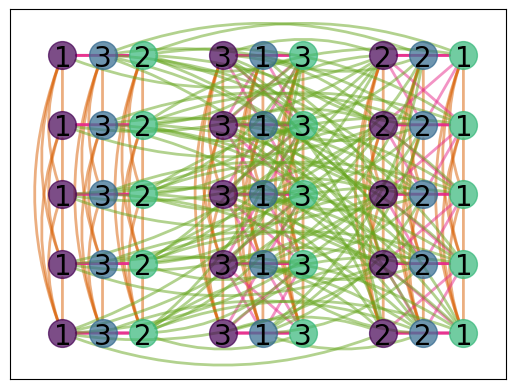

In [ ]:
##FULL GRAPH PLOT

color_array = np.zeros((1,4))
for job in task_groups:
    for i,task in enumerate(task_groups[job]):
        color_array[0] = cmap_nodes(job/len(task_groups))
        nx.draw_networkx_nodes(graph, pos_dict, node_size=node_size, nodelist=task, node_color=color_array, alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph, pos_dict, labels, font_size=20, verticalalignment='center_baseline')
        
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_curved, arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_straight, arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=otm_straight, arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.4))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=oo_straight, arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.6))


plt.show()

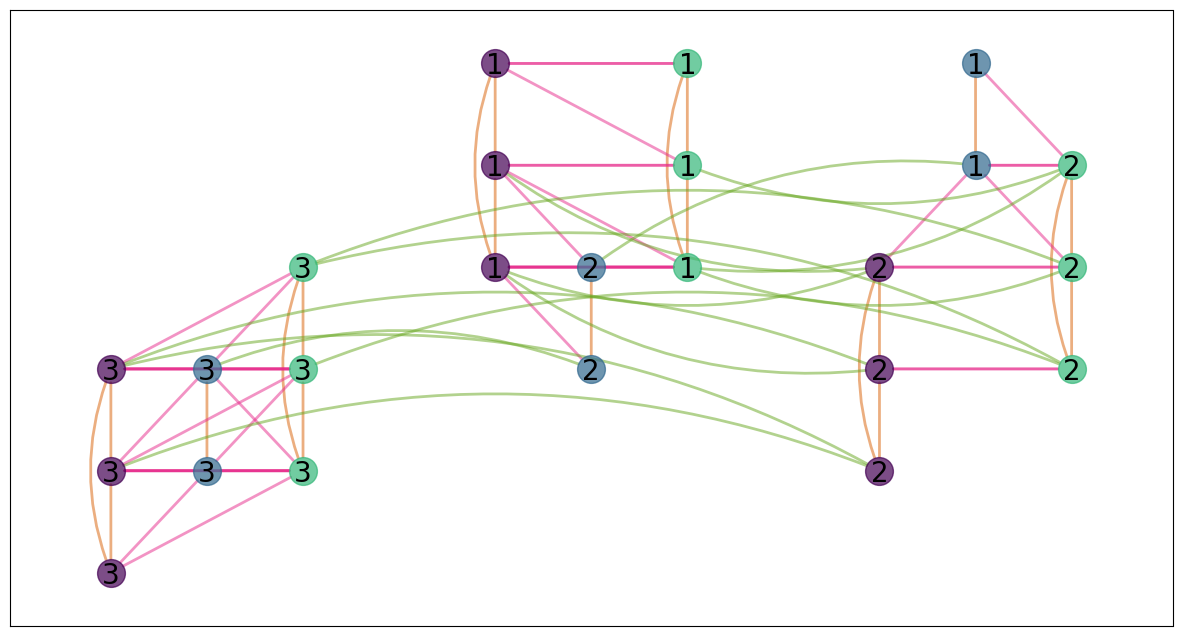

In [19]:
#PRUNED GRAPH PLOT

color_array = np.zeros((1,4))

plt.figure(figsize=(15,8))
for job in task_groups2:
    for i,task in enumerate(task_groups2[job]):
        color_array[0] = cmap_nodes(job/len(task_groups))
        nx.draw_networkx_nodes(graph2, pos_dict2, node_size=node_size, nodelist=task, node_color=color_array, alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph2, pos_dict2, labels, font_size=20, verticalalignment='center_baseline')
        
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[0], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[1], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[2], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.4))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[3], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.6))


plt.show()

In [ ]:
instance

{0: [(0, 1), (1, 2), (2, 1)],
 1: [(0, 2), (1, 2), (2, 1)],
 2: [(1, 2), (2, 2), (0, 2)],
 3: [(2, 2), (1, 2), (0, 1)],
 'timespan': 5}

# Embedding

## Target initialization and visualization

In [5]:
#TARGET GRAPH

target = dnx.pegasus_graph(2)

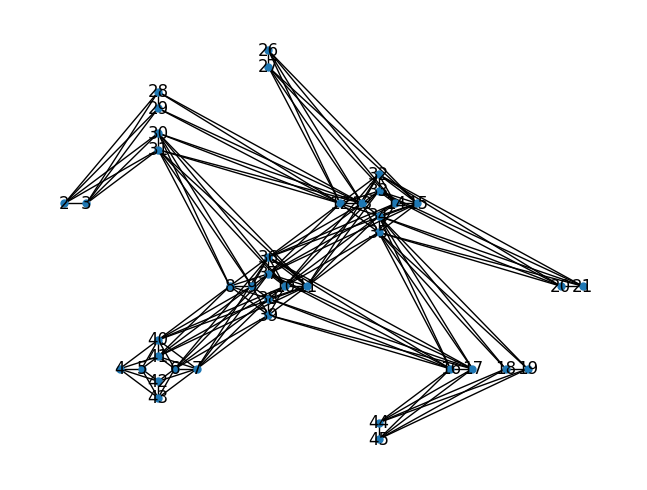

In [ ]:
dnx.draw_pegasus(target, node_size=25, crosses=True, with_labels=True)

In [9]:
g_size = 10

template_target = nx.Graph()

for i in range(g_size):
    template_target.add_node((0,i), pos=(0,i))
    template_target.add_node((1,i), pos=(1,i))

for i in range(g_size):
    for j in range(g_size):
        template_target.add_edge((0,i),(1,j))

pos_dict = {}
for n in template_target.nodes:
    pos_dict[n] = template_target.nodes[n]['pos']

In [12]:
def build_template(g_size):
    template = nx.Graph()

    for i in range(g_size):
        template.add_node((0,i), pos=(0,i))
        template.add_node((1,i), pos=(1,i))

    for i in range(g_size):
        for j in range(g_size):
            template.add_edge((0,i),(1,j))

    pos_dict = {}
    for n in template.nodes:
        pos_dict[n] = template.nodes[n]['pos']
    
    return template, pos_dict

In [29]:

template, pos_template = build_template(8)
nx.is_bipartite(template)

True

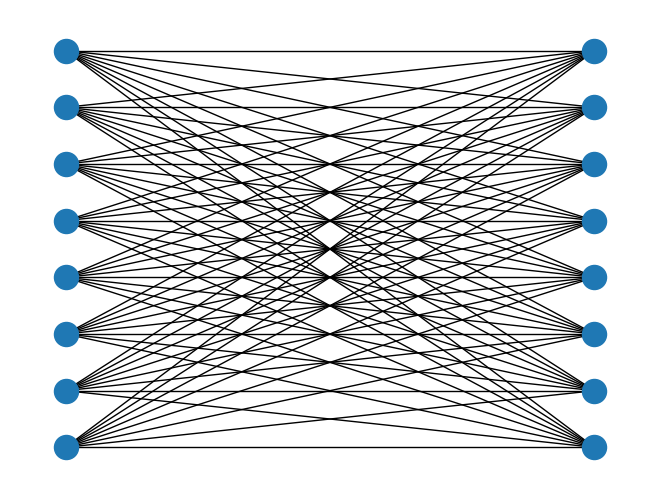

In [30]:
nx.draw(template, pos_template)

## DWave default minor-embedding

In [ ]:
#DWAVE default minor-embedding

embedding = minorminer.find_embedding(graph2, target)

if len(embedding.keys()) == 0:
    print('Embedding failed')

else:
    print('Embedding succesful')
    e_size = 0
    max_chain = 1

    for k in embedding:
        e_size += len(embedding[k])
        if len(embedding[k]) > max_chain:
            max_chain = len(embedding[k])

    print(f'Embedding size: {e_size}')
    print(f'Max chain: {max_chain}')

Embedding failed


In [ ]:
embedding

{(0, 0, 1): [31],
 (0, 0, 2): [11],
 (2, 0, 1): [10],
 (0, 2, 1): [9],
 (0, 1, 1): [8],
 (1, 0, 2): [36],
 (0, 1, 2): [30],
 (1, 0, 3): [14],
 (1, 2, 2): [37],
 (1, 1, 2): [12],
 (1, 2, 3): [15],
 (1, 1, 3): [26],
 (2, 0, 0): [34],
 (2, 1, 0): [17],
 (2, 2, 1): [39],
 (2, 1, 1): [38],
 (0, 2, 0): [40],
 (2, 2, 2): [6]}

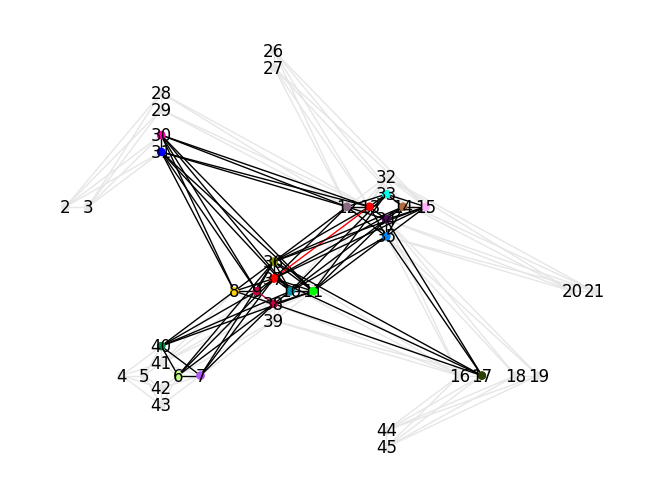

In [ ]:
dnx.draw_pegasus_embedding(target, embedding, node_size=25, crosses=True, with_labels=True)

## IP minor-embedding

Given a source graph (logical graph) Y and a target graph X, a minor-embedding is the map $ϕ$ from Y to the connected subtrees of X with the following proprieties:

1. for each $(y_{i_1},y_{i_2}) \in E(Y)$ there exist at least one edge in X connecting $\phi(y_{i_1}), \phi(y_{i_2})$

2. $\phi(y_{i_1}) \cap \phi(y_{i_2}) = 	\emptyset \quad  ∀ i_1,i_2$

### One-problem approach

Here the problem of finding a minor-embedding is treated as a single Integer Program, where the constraints are a equational formulation of the conditions listed above

#### Functions

Here are the functions used to define the variables needed to solve the problem.

To accomplish this 3 sets of variables has to be defined:


1.   Binary decision variables: $α_{i,j}$ where $i:x_i\in V(X), j:y_j\in V(Y)$.

  $\alpha_{i,j} = 1 \Leftrightarrow x_i \in ϕ(y_j)$

2.   Additional variables: $γ_{c_k,j} = \prod_{l:x_l\in int(c_k(x_{i_1},x_{i_2}))}\alpha_{l,j}$ where $c_k(x_{i_1}, x_{i_2}) \in C_k(x_{i_1},x_{i_2})$  the set of all chains connecting $x_{i_1},x_{i_2}$ with lenght at most $k$

3. Additional variables: $δ_{i_1,i_2,j_1,j_2}^{∥} = \alpha_{i_1,j_1}\alpha_{i_2,j_2}$ and $\delta_{i_1,i_2,j_1,j_2}^{\perp} = \alpha_{i_1,j_2}\alpha_{i_2,j_1}$

NOTE: the 2 additional sets of variables are defined to better formalize the constraints


In [ ]:
def define_decision_variables(target, graph, model):

    var_dict = {}
    for v in target.nodes:
        for w in graph.nodes:
            var_dict[(v,w)] = model.addVar(vtype=GRB.BINARY, name=f'x_{v},{w}')
    return var_dict

In [ ]:
def define_gamma_variables(chains, j, k, var_dict, model):
    ls = []
    for c in chains:
        if len(c) > 0:
            ls.append(model.addVar(vtype=GRB.BINARY, name=f'gamma_{c}_{j}'))

            s = 1
            for i in range(1, len(c)-1):
                s *= var_dict[c[i],j]
            model.addConstr( ls[-1] == s )

    return ls

In [ ]:
def define_delta_p_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y1)] * var_dict[(x2,y2)])
    return delta

def define_delta_o_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y2)] * var_dict[(x2,y1)])
    return delta

**Embedding size constraints:**

$$min\_size \leq \sum_{i,j} \alpha_{i,j} \leq max\_size$$

trivial bounds for the min/max size are:
* $min\_size = |V(Y)|$
* $max\_size = |V(X)|$

In [ ]:
def add_size_constraint(var_dict, model, max, min):
    model.addConstr(sum(var_dict.values()) <= max, name='size_constraint')
    model.addConstr(sum(var_dict.values()) >= min, name='size_constraint')

**Well-definition constraints:**
$$\sum_j \alpha_{i,j} \leq 1$$

this enforce the property 2. of the embedding

In [ ]:
def add_wd_constraint(target, graph, var_dict, model):
    for n in target.nodes:
        tmp = 0
        for k in graph.nodes:
            tmp += var_dict[(n,k)]
        
        model.addConstr(tmp <= 1, name=f'well_defined_constraint_{n}')

**Fiber size constraints:**
$$1 \leq \sum_i \alpha_{i,j} \leq k$$

there is also the implementation of an additional refinement which excludes $x_{i_1}, x_{i_2}$ from being part of $\phi(y_j)$ if the distance between them is greater than $k$.

In [ ]:
def add_fs_constraint(target, graph, var_dict, model, k):
    for n in graph.nodes:
        tmp = 0
        for k in target.nodes:
            tmp += var_dict[k,n]
        
        model.addConstr(tmp <= k, name=f'fiber_size_max_constraint_{n}')
        model.addConstr(tmp >= 1, name=f'fiber_size_min_constraint_{n}')

def add_fs_refinement(target, graph, var_dict, model, k):
    ls = set()
    t_nodes = set(target.nodes)
    for x1 in t_nodes:
        ls.add(x1)
        for x2 in t_nodes-ls:
            chains = list(nx.all_simple_paths(target, x1, x2, k))
            if len(chains) == 0:
                for j in graph.nodes:
                    tmp = var_dict[x1,j] + var_dict[x2,j]
                    model.addConstr(tmp <= 1, name=f'fs_ref_{j}_{x1}_{x2}')

**Pullback condition:**

$$1 \leq \sum_{i_1,i_2:(x_{i_1},x_{i_2}) \in E(X)} (\delta_{i_1,i_2,j_1,j_2}^{\perp} + \delta_{i_1,i_2,j_1,j_2}^{\parallel})\quad \forall (y_{j_1},y_{j_2} \in E(Y)$$

this is equivalent to the condition 1. of a minor-embed

In [ ]:
def add_pullback_constraint(target, graph, model, var_dict):
    for ey in graph.edges:
        s = 0
        for ex in target.edges:
            d_p = define_delta_p_variable(ex[0], ex[1], ey[0], ey[1], var_dict, model)
            d_o = define_delta_o_variable(ex[0], ex[1], ey[0], ey[1], var_dict, model)

            s += d_p+d_o
            model.addConstr(s <= 1, name=f'pullback_ds_{ey}_{ex}')
        model.addConstr(1 <= s, name=f'pullback_{ey}')

**Fiber Condition:**

$$\alpha_{i_1,j} + \alpha_{i_2,j} + \sum_{c_k  x_{i_1},x_{i_2}) \in C_k(x_{i_1},x_{i_2})} \gamma_{c_k,j} -1 \leq 2 \quad \forall x_{i_1},x_{i_2} \in \phi(y_j)$$

this ensure that the vertex models are connected subtrees of X

In [ ]:
def add_fiber_constraint(graph, target, k, var_dict, model):
    for j in graph.nodes:
        ls = set()
        t_nodes = set(target.nodes)
        for x1 in t_nodes:
            ls.add(x1)
            for x2 in t_nodes-ls:

                chains = list(nx.all_simple_paths(target, x1, x2, k))
                if len(chains) > 0:
                    gammas = define_gamma_variables(chains, j, k, var_dict, model)

                    model.addConstr( var_dict[(x1,j)] + var_dict[(x2,j)] + sum(gammas) - 1 <= 2)
            
                

In [ ]:
def validate_embedding(embedding, target, graph):

  
  target_edges = list(target.edges)
  edge_valid = True
  node_valid = True
  used_target_nodes = []
  for node in graph.nodes:

    #edges validation (for every edge (y_1,y_2) there must be an edge
    #(chain(y_1), chain(y_2)) in the target
    neighbors = list(graph.neighbors(node))
    chain_node = embedding[node]
    if len(neighbors) > 0:
      edge_valid = False
      for neig in neighbors:
        chain_neig = embedding[neig]
        for x1 in chain_node:
          for x2 in chain_neig:
            if (x1,x2) in target_edges or (x2,x1) in target_edges:
              edge_valid = True
    
    #check that every chain is made of different nodes
    for n in chain_node:
      if n in used_target_nodes:
        node_valid = False
      else:
        used_target_nodes.append(n)

    #if the node embedding is not valid return false
    if not edge_valid or not node_valid:
      return edge_valid, node_valid
  
  return edge_valid, node_valid
      


In [ ]:
def ip_embed_preprocess(var_dict, graph):
  ip_embedding = {}
 
  for j in graph:
      ip_embedding[j] = []
      for x, y in var_dict:
          if y == j:
              if var_dict[x,j].X > 0.5:
                  ip_embedding[j].append(x)
  return ip_embedding

#### Execution

In [ ]:
#Model initialization
model = gb.Model("minor-embedding", env=env)

max_size = len(target.nodes)
min_size = len(graph2.nodes)
print(f'Min_size: {min_size}')
print(f'Max_size: {max_size}')
k = 1

var_dict = define_decision_variables(target, graph2, model)
model.update()

Min_size: 18
Max_size: 40


In [ ]:
print(f'Decision variables: {len(var_dict)}')

add_size_constraint(var_dict, model, max_size, min_size)
model.update()

c = len(list(model.getConstrs()))
print(f'Size constraints: {c}')

add_wd_constraint(target, graph2, var_dict, model)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Well Definition constraints: {c}')

add_fs_constraint(target, graph2, var_dict, model, k)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Size constraints: {c}')

add_fs_refinement(target, graph2, var_dict, model, k)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Size refinement: {c}')

add_pullback_constraint(target, graph2, model, var_dict)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Pullback constraints: {c}')

add_fiber_constraint(graph2, target, k, var_dict, model)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Condition constraints: {c}')



Decision variables: 720
Size constraints: 37937
Well Definition constraints: 40
Fiber Size constraints: 37973
Fiber Size refinement: 11128
Pullback constraints: 41768
Fiber Condition constraints: 17032


In [ ]:
model.Params.timeLimit = 600

Set parameter TimeLimit to value 600


In [ ]:
model.setObjective(sum(var_dict.values()), GRB.MINIMIZE)



In [ ]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 20865 rows, 11216 columns and 667508 nonzeros
Model fingerprint: 0x73c4e23d
Model has 7544 quadratic constraints
Variable types: 0 continuous, 11216 integer (11216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 17572 rows and 2938 columns
Presolve time: 1.49s
Presolved: 33469 rows, 15822 columns, 442200 nonzeros
Variable types: 0 continuous, 15822 integer (15822 binary)

Root relaxation: objective 1.800000e+01, 5909 iterations, 1.63 seconds (1.66 work units)
T

In [ ]:
ip_embedding = {}
 
for j in graph2:
    ip_embedding[j] = []
    for x, y in var_dict:
        if y == j:
            if var_dict[x,j].X > 0.5:
                ip_embedding[j].append(x)

In [ ]:
dnx.draw_pegasus_embedding(target, ip_embedding, node_size=25, crosses=True, with_labels=True)

In [ ]:
dnx.draw_pegasus_embedding(target, embedding, node_size=25, crosses=True, with_labels=True)

In [ ]:
validate_embedding(ip_embedding, target, graph2)

True

### Decomposition approach

In this section is implemented an alternative way of solving the problem, we start with a master problem in which we relax the fiber condition, then we check the connectivity of the solution and add a constraint to the model that eliminate the current solution and encourage the solver torward feasible solutions.

Note that, missing only the fiber condition, if the source graph is embeddable without chains, then the solution is feasible and optimal after the first iteration of the master problem.

#### Functions

The 2 sets of variables needed nex to the $\alpha_{i,j}$ are:

* $z_{e_x,e_y}\quad \forall e_x \in E(X),e_y \in E(Y)$

  those variables takes value 1 if the target edge $e_y$ is embedded in the edge $e_x$ 

* $\omega_j \quad \forall y_j \in V(Y)$

  $\omega_j$ takes value 1 if $y_j$ is mapped to more than one node in X.

  NOTE: the last set of variables are needed only for a refinement constraint that can eventually be omitted


In [ ]:
def define_edge_decision_varaibles(target, graph, model):
  edge_var_dict = {}
  for e_x in target.edges:
    for e_y in graph.edges:
      edge_var_dict[(e_x,e_y)] = model.addVar(vtype=GRB.BINARY, name=f'z_{e_x},{e_y}')
  
  return edge_var_dict

In [ ]:
def define_w_variables(target, graph, model):
  w_var_dict = {}
  for y in graph.nodes:
    w_var_dict[y] = model.addVar(vtype=GRB.BINARY, name=f'w_{y}')
  return w_var_dict

**Assigment constraints:**
$$\sum_{e_x \in E(X)} z_{e_x,e_y} =1, ∀ e_y \in E(Y)$$

this ensures that each edge in the source graph is assigned to an edge in the target graph.


In [ ]:
def add_assignment_constraint(target, graph, var_dict, edge_var_dict, model):
  
  for e_y in graph.edges:
    s=0
    for e_x in target.edges:
      s += edge_var_dict[e_x,e_y]
    model.addConstr(s == 1, name = f'asg_const_{e_y}')

**Linking constraints:**

$$z_{e_x,e_y} \leq \alpha_{e_{x,1}, e_{y,1}} \cdot \alpha_{e_{x,2}, e_{y,2}} + \alpha_{e_{x,1}, e_{y,2}} \cdot \alpha_{e_{x,2}, e_{y,1}}$$

with this we require that an endge in the source graph can be assigned to an edge in the target graph only inf the nodes takes part in the vertex models of the source nodes.

In [ ]:
#TEMPORARY, PROBABLY WRONG

def add_link_constraint(target, graph, var_dict, edge_var_dict):
  for e_x in target.edges:
    for e_y in graph.edges:
      model.addConstr(2*edge_var_dict[(e_x,e_y)] <= var_dict[(e_x[0],e_y[0])] + var_dict[(e_x[1],e_y[1])], name=f'link_{e_x},{e_y}'  )

In [ ]:
def add_link_constraint(target, graph, var_dict, edge_var_dict):
  for e_x in target.edges:
    for e_y in graph.edges:
      model.addConstr(edge_var_dict[(e_x,e_y)] <= var_dict[e_x[0],e_y[0]] * var_dict[e_x[1],e_y[1]] + var_dict[e_x[1],e_y[0]] * var_dict[e_x[0],e_y[1]], name=f'link_{e_x},{e_y}'  )

**Subproblem relaxation:**

$\forall y_j \in V(Y)$
$$ \sum_i \alpha_{i,j} -n\cdot \omega_j \leq 1$$
$$ n(1-\alpha_{i,j}) + \sum_{l:(x_i,x_l)\in E(X)} \alpha_{l,j} + \ge \omega_j, ∀x_i \in V(X)$$

this should guide the model torwards feasible solutions

In [ ]:
def add_sub_relax_constraint(target, graph, var_dict, edge_var_dict, model):
  n = len(list(target.nodes))
  s = 0
  for y in graph.nodes:
    s = 0
    for x in target.nodes:
      s += var_dict[(x,y)]

      tmp = 0
      for e_x in target.edges:
        if x in e_x:
          if e_x[0] != x:
            tmp += var_dict[(e_x[0],y)]
          else:
            tmp += var_dict[(e_x[1],y)]
      model.addConstr(  n*(1 - var_dict[(x,y)]) + tmp >= w_var_dict[y], name=f'sub_relax_{x},{y}'   )

    model.addConstr(s <= 1 + n*w_var_dict[y], name=f'sub_relax_{y}')

**Subproblem:**

Checks if there are vertices, belonging to the same vertex model $\phi(y)$, that are disconnected in the target graph then add a set of constraints to the model that:
1. removes the current solution.
2. prevents the future solutions from having the same disconnectivity

Let's call the set of indexes related to the disconnected nodes $\hat Y$, then the set of vertices that belong to this vertex model are represented as $\phi(y_{\hat j}) \subseteq V(X)$. The constraints take the following form:

$$|\phi(y_{\hat j})| - \sum_{i:x_i\in \phi(y_{\hat j})}  \alpha_{i, \hat j} + \sum_{i:x_i\in \phi'(y_{\hat j})}  \alpha_{i, \hat j} \ge 1$$

where $\phi'(y_j)$ is the set of vertices of $X$ adjacent to any vertex in $\phi(y_j)$ but not part of the vertex model.

This encourage the model to:

1. add a new vertex from the adjacent ones to improve connectivity
2. remove a vertex to discard disconnections

In [ ]:
def subproblem(target, embedding, var_dict, model, iter):

  #Connection check
  t_edges = target.edges
  convergence = 0
  for k in embedding:
    valid = True
    v_model = embedding[k]
    if len(v_model) > 1:
      for x1 in set(v_model):
        connected = False
        for x2 in set(v_model)-{x1}:
          if (x1,x2) in t_edges or (x2,x1) in t_edges:
            connected = True
        if not connected:
          valid = False

    if not valid:
      convergence += 1
      tmp1 = 0
      tmp2 = 0
      model_size = len(v_model)

      for v in v_model:
        tmp1 += var_dict[(v,k)]

        neighbor = target.neighbors(v)
        found = []
        for n in neighbor:
          
          if not( n in v_model ) and not( n in found ):
            found.append(n)
            tmp2 += var_dict[(n,k)]
      print(f'node {k} not connected')

      exp = model_size - tmp1 + tmp2
      model.addConstr(exp >= 1, name=f'subproblem_{iter}')
  return convergence




#### Execution

In [ ]:
model = gb.Model("minor-embedding", env=env)

max_size = len(target.nodes)
min_size = len(graph2.nodes)
print(f'Min_size: {min_size}')
print(f'Max_size: {max_size}')
k = 1

var_dict = define_decision_variables(target, graph2, model)
edge_var_dict = define_edge_decision_varaibles(target, graph2, model)
w_var_dict = define_w_variables(target, graph2, model)
model.update()

Min_size: 24
Max_size: 40


In [ ]:
edge_var_dict[(2, 3),((0, 0, 1), (0, 0, 2))]

<gurobi.Var z_(2, 3),((0, 0, 1), (0, 0, 2))>

In [ ]:
add_assignment_constraint(target, graph2, var_dict, edge_var_dict, model)
model.update()

c = len(list(model.getConstrs()))
print(f'Assignment contraints: {c}')

a = add_link_constraint(target, graph2, var_dict, edge_var_dict)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Linking constraints: {c}')

#add_sub_relax_constraint(target, graph2, var_dict, edge_var_dict, model)
#model.update()

#c = len(list(model.getConstrs())) - c
#print(f'Subproblem relaxation constraints: {c}')

add_wd_constraint(target, graph2, var_dict, model)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Well Definition constraints: {c}')

add_fs_constraint(target, graph2, var_dict, model, k)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Size constraints: {c}')

Assignment contraints: 70
Linking constraints: 0
Well Definition constraints: 110
Fiber Size constraints: 48


In [ ]:
model.setObjective(sum(var_dict.values()), GRB.MINIMIZE)

In [ ]:
model.Params.MIPGap = 0.3

Set parameter MIPGap to value 0.3


In [ ]:
model.Params.LogToConsole = 0

In [ ]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 158 rows, 12464 columns and 14360 nonzeros
Model fingerprint: 0x16805ae1
Model has 11480 quadratic constraints
Variable types: 0 continuous, 12464 integer (12464 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 24 rows and 24 columns
Presolve time: 0.36s
Presolved: 57534 rows, 35400 columns, 139680 nonzeros
Variable types: 0 continuous, 35400 integer (35400 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 2

In [ ]:
convergence = 1
max_iter = 500
iter = 0

while iter<max_iter and convergence>0:
  iter += 1
  print(f'iter n :{iter}')
  model.optimize()
  ip_embedding = ip_embed_preprocess(var_dict, graph2)
  convergence = subproblem(target, ip_embedding, var_dict, model, iter)
  model.update()
  print(f'number of invalid models :{convergence}')

iter n :1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 9163 rows, 10004 columns and 38960 nonzeros
Model fingerprint: 0x02ce79ab
Variable types: 0 continuous, 10004 integer (10004 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 24 rows and 24 columns
Presolve time: 0.07s
Presolved: 9139 rows, 9980 columns, 38000 nonzeros
Variable types: 0 continuous, 9980 integer (9980 binary)

Root relaxation: objective 2.400000e+01, 3381 iterations, 0.18 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

AttributeError: ignored

In [ ]:
ip_embedding

{(0, 0, 0): [29],
 (0, 0, 1): [13, 34],
 (0, 0, 2): [6, 39],
 (1, 0, 2): [19],
 (1, 0, 3): [15, 36],
 (1, 0, 4): [44],
 (2, 0, 3): [14, 26],
 (2, 0, 4): [4, 42],
 (2, 0, 5): [30],
 (0, 1, 2): [10],
 (0, 1, 3): [32],
 (1, 1, 3): [5, 43],
 (1, 1, 4): [18],
 (2, 1, 0): [11],
 (2, 1, 1): [35],
 (0, 2, 1): [7, 38],
 (0, 2, 2): [33],
 (0, 2, 3): [20],
 (1, 2, 0): [2],
 (1, 2, 1): [28],
 (1, 2, 2): [40, 41],
 (2, 2, 2): [21],
 (2, 2, 3): [17, 45],
 (2, 2, 4): [8, 31]}

In [ ]:
validate_embedding(ip_embedding, target, graph2)

(True, True)

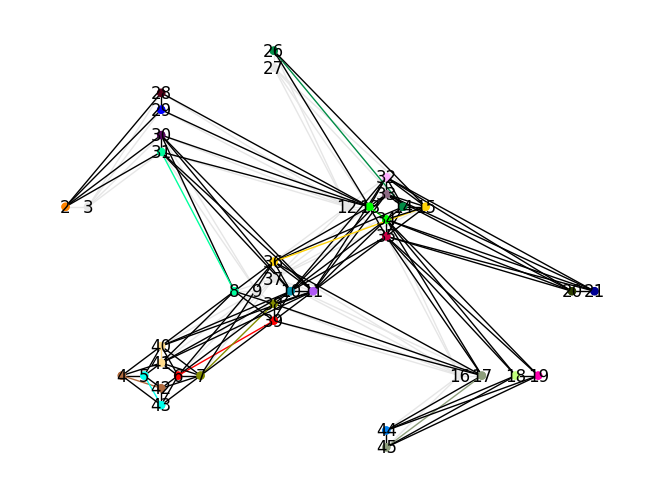

In [ ]:
dnx.draw_pegasus_embedding(target, ip_embedding, node_size=25, crosses=True, with_labels=True)

### Template approach

#### Functions

In [8]:
def define_template_variables(graph, k, model):
    yp_dict = {}
    y_dict = {}
    for n in graph.nodes:
        yp_dict[n] = model.addVar(vtype=GRB.BINARY, name=f'y_{n}')
        for i in range(k):
            y_dict[(n,i)] = model.addVar(vtype=GRB.BINARY, name=f'y_{n},{i}')
    return y_dict, yp_dict

In [9]:
def add_association_constraint(y_dict, yp_dict, graph, model):
    for n in graph.nodes:
        model.addConstr(yp_dict[n] <= y_dict[(n,0)] + y_dict[(n,1)], name=f'assoc_{n}')

In [10]:
def add_gsize_constraint(y_dict, graph, max_size, k, model):
    for i in range(k):
        s = 0
        for n in graph.nodes:
            s += y_dict[(n, i)]
        model.addConstr( s <= max_size, name = f'max_gsize_{i}')

In [13]:
def add_nsp_constraint(y_dict, graph):
    for e in graph.edges:
        exp = y_dict[e[0],0] + y_dict[e[1],0] - y_dict[e[0],1] - y_dict[e[1],1]
        model.addConstr(exp <= 1, name = f'+nsp_constr_{e}')
        model.addConstr(exp >= -1, name = f'-nsp_constr_{e}')

#### Execution

In [31]:
model = gb.Model("minor-embedding")
k = 2
y_dict, yp_dict = define_template_variables(graph2, k, model)

In [32]:
add_association_constraint(y_dict, yp_dict, graph2, model)
add_gsize_constraint(y_dict, graph2, 10, k, model)
add_nsp_constraint(y_dict, graph2)

In [33]:
model.setObjective(sum(yp_dict.values()), GRB.MAXIMIZE)

In [34]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 154 rows, 72 columns and 632 nonzeros
Model fingerprint: 0x8b6f26b7
Variable types: 0 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 154 rows, 72 columns, 632 nonzeros
Variable types: 0 continuous, 72 integer (72 binary)
Found heuristic solution: objective 14.0000000

Root relaxation: objective 2.000000e+01, 54 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.00